In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
import torch
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import AutoProcessor, Pix2StructForConditionalGeneration
from transformers.optimization import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split

from train import train_model
from dataset import RealCQA, prepare_dataloaders
from config import Config, seed_everything

In [10]:
cfg = Config()

In [11]:
seed_everything(cfg.RANDOM_SEED)

In [12]:
processor = AutoProcessor.from_pretrained("google/matcha-chartqa")

In [6]:
train_dl, test_dl = prepare_dataloaders(cfg, processor)

In [13]:
matcha_chartqa = Pix2StructForConditionalGeneration.from_pretrained("google/matcha-chartqa").to(cfg.DEVICE)

In [14]:
optimizer = torch.optim.AdamW(matcha_chartqa.parameters(), lr=1e-4)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=120, num_training_steps=600)

In [15]:
train_model(model=matcha_chartqa,
            optimizer=optimizer,
            train_dl=train_dl,
            test_dl=test_dl,
            num_epochs=1,
            processor=processor,
            device=cfg.DEVICE,
            scheduler=scheduler,
            neptune_tracking=True,
            model_name="matcha-chartqa"
            )

https://app.neptune.ai/bng215/Model-Collapse/e/TRAN-1004


Epoch: 1: Train stage:  11%|█         | 656/6007 [2:05:16<17:01:49, 11.46s/it]  


KeyboardInterrupt: 

In [17]:
matcha_base = Pix2StructForConditionalGeneration.from_pretrained("google/matcha-base").to(cfg.DEVICE)

config.json:   0%|          | 0.00/4.89k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

In [18]:
optimizer = torch.optim.AdamW(matcha_base.parameters(), lr=1e-4)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=120, num_training_steps=600)

In [19]:
train_model(model=matcha_base,
            optimizer=optimizer,
            train_dl=train_dl,
            test_dl=test_dl,
            num_epochs=1,
            processor=processor,
            device=cfg.DEVICE,
            scheduler=scheduler,
            neptune_tracking=True,
            model_name="matcha-base"
            )

https://app.neptune.ai/bng215/Model-Collapse/e/TRAN-1005


Epoch: 1: Train stage:  12%|█▏        | 699/6007 [2:14:32<17:01:40, 11.55s/it]


KeyboardInterrupt: 

In [13]:
matcha_plotqa = Pix2StructForConditionalGeneration.from_pretrained("google/matcha-plotqa-v1").to(cfg.DEVICE)

pytorch_model.bin:  17%|#6        | 189M/1.13G [00:00<?, ?B/s]

In [14]:
optimizer = torch.optim.AdamW(matcha_plotqa.parameters(), lr=1e-4)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=120, num_training_steps=600)

In [16]:
train_model(model=matcha_plotqa,
            optimizer=optimizer,
            train_dl=train_dl,
            test_dl=test_dl,
            num_epochs=1,
            processor=processor,
            device=cfg.DEVICE,
            scheduler=scheduler,
            neptune_tracking=True,
            model_name="matcha-plotqa"
            )

https://app.neptune.ai/bng215/Model-Collapse/e/TRAN-1006


Epoch: 1: Train stage:  12%|█▏        | 699/6007 [2:23:22<18:08:46, 12.31s/it]


KeyboardInterrupt: 

: 

In [13]:
matcha_base = Pix2StructForConditionalGeneration.from_pretrained("google/matcha-base").to(cfg.DEVICE)

In [16]:
matcha_base.load_state_dict(torch.load('weights/matcha-base/matcha-base_step_500.pth')['state_dict'])

<All keys matched successfully>

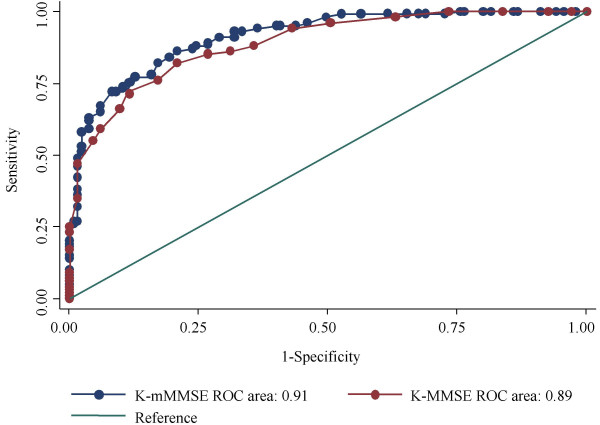

In [17]:
test_image = Image.open("test_sample.jpg")
test_image

In [18]:
question = "What is the type of chart?"
answer = "Line chart"

In [19]:
inputs = processor(images=test_image, text=question, return_tensors="pt", max_patches=768).to(cfg.DEVICE)

In [20]:
predictions = matcha_base.generate(flattened_patches=inputs['flattened_patches'], attention_mask=inputs['attention_mask'])

In [22]:
decoded_prediction = processor.batch_decode(predictions, skip_special_tokens=True)[0]

In [23]:
decoded_prediction

'Line chart'